# Process Capability
The data should be organised in the following format

- column 1: sample lables 
- column 2 to n: are the samples in one subgroup
- no more columns should be present in the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
data = pd.read_csv('process capability_data.csv')

In [3]:
def process_capability(data , lsl , usl):
    
    # basic statistics
    N = len(data.iloc[:,1:len(data.columns)].stack())
    subgroups = len(data.columns)-1
    data_mean = data.iloc[:,1:len(data.columns)].mean(axis=1).mean()
    std_overall = data.iloc[:,1:len(data.columns)].stack().std() 
    
    # calculate std_within differently if we have subgroups of 1
    if subgroups == 1:
        std_within = (pd.DataFrame({'t':data.iloc[:,1], 't+1': data.iloc[:,1].shift(1) }).std(axis=1)**2).mean()**(0.5)
    else:
        std_within = (data.iloc[:,1:len(data.columns)].std(axis=1)**2).mean()**(0.5)
    
    # prep normal curve for graph 
    norm_overall = np.random.normal(loc=data_mean, scale=std_overall, size=100_000)
    norm_within = np.random.normal(loc=data_mean, scale=std_within, size=100_000)
    
    # plot Capability Histogram
    plt.figure(figsize=(12,6))

    ax =sns.distplot(data.iloc[:,1:len(data.columns)], hist=True,
                     kde=False, bins=int(N/7), color = 'blue', hist_kws={'edgecolor':'black'})

    # plot Actual(Overall)
    ax = sns.distplot(norm_overall,
                      hist=False, kde=True,
                      kde_kws={'linewidth': 2,'color':'#b33939','alpha':1,
                               'label':'Actual (overall) capability is what the customer experiences.'})

    ax = sns.distplot(norm_within,
                      hist=False, kde=True, 
                      kde_kws={'linewidth': 2,'color':'#57606f', 'alpha':1, 'ls' : '--',
                               'label':'Potential (within) capability is what could be \
    achieved if process shifts and drifts were eliminated.'})


    plt.title('Capability Histogram')
    plt.axvline(lsl, color = 'red', ls = '--', linewidth = 1, label= 'Upper & Lower spec limits')
    plt.axvline(usl, color = 'red', ls = '--', linewidth = 1, )
    plt.legend(bbox_to_anchor=(0.79, -0.05))
    ax.yaxis.set_visible(False)
    plt.show()

    # Overall

    # Calculate Pp & Ppk
    pp = (usl - lsl)/(6*std_overall)
    ppk = min([(usl - data_mean)/(3*std_overall),(data_mean-lsl)/(3*std_overall)])

    # Calculate Z score
    z_upper = (usl - data_mean)/(std_overall)
    z_lower = (data_mean-lsl)/(std_overall)
    # use statistical tables to get p & z values
    z_bench = np.abs(stats.norm.ppf((1-stats.norm.cdf(z_upper)) + (1-stats.norm.cdf(z_lower))))

    # Calculate % out-of-specs observed
    above_usl =  (data.iloc[:,1:len(data.columns)].stack()>usl).sum()
    below_lsl =  (data.iloc[:,1:len(data.columns)].stack()<lsl).sum()
    total_observations = data.iloc[:,1:len(data.columns)].stack().count()
    oos_observed = (above_usl + below_lsl)*100/total_observations

    # Calculate % out-of-specs predicted
    oos_expected =  ((1-stats.norm.cdf(z_upper)) + (1-stats.norm.cdf(z_lower))) * 100


    # Within

    # Calculate Cp & Cpk
    cp = (usl - lsl)/(6*std_within)
    cpk = min([(usl - data_mean)/(3*std_within),(data_mean-lsl)/(3*std_within)])

    # Calculate Z score
    z_upper_w = (usl - data_mean)/(std_within)
    z_lower_w = (data_mean-lsl)/(std_within)
    z_bench_w = np.abs(stats.norm.ppf((1-stats.norm.cdf(z_upper_w)) + (1-stats.norm.cdf(z_lower_w))))

    # Calculate % out-of-specs predicted
    oos_expected_w = ((1-stats.norm.cdf(z_upper_w)) + (1-stats.norm.cdf(z_lower_w))) * 100


    print('______Process Charecterisation_______')
    print(f'Total N :  {N}')
    print(f'Subgroup size :  {subgroups} ')
    print(f'Mean :  {np.round(data_mean, 4)} ')
    print(f'Standard Deviation (Overall) :  {np.round(std_overall, 5)}')
    print(f'Standard Deviation (within) :  {np.round(std_within, 5)}')
    print('')
    print('______Capability Statistics_______')
    print('Actual (overall)')
    print(f'    Pp :  {np.round(pp, 2)}')
    print(f'    Ppk :  {np.round(ppk, 2)}')
    print(f'    Z.Bench :  {np.round(z_bench, 2)}')
    print(f'    % out-of-specs (oberved) :  {np.round(oos_observed, 2)}')
    print(f'    % out-of-specs (predicted) :  {np.round(oos_expected, 2)}')
    print('')
    print('Potential (within)')
    print(f'    Cp :  {np.round(cp, 2)}')
    print(f'    Cpk :  {np.round(cpk, 2)}')
    print(f'    Z.Bench :  {np.round(z_bench_w, 2)}')
    print(f'    % out-of-specs (predicted) :  {np.round(oos_expected_w, 2)}')
    print('')
    print('''- Examine control charts for process stability
- Ensure more than 25 subgroups are considered for the study
- Make sure the data can pass a normality test
- Total number of observations should be above 100
- You must have a Cpk of 1.33 [4 sigma] or higher to satisfy most customers
    ''')

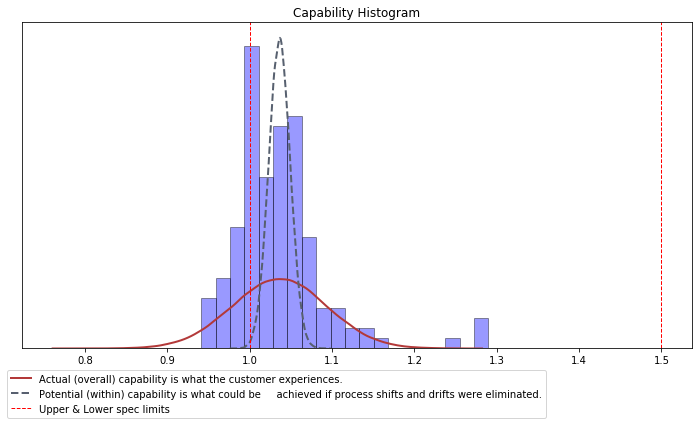

______Process Charecterisation_______
Total N :  144
Subgroup size :  4 
Mean :  1.0363 
Standard Deviation (Overall) :  0.05766
Standard Deviation (within) :  0.01303

______Capability Statistics_______
Actual (overall)
    Pp :  1.45
    Ppk :  0.21
    Z.Bench :  0.63
    % out-of-specs (oberved) :  21.53
    % out-of-specs (predicted) :  26.47

Potential (within)
    Cp :  6.39
    Cpk :  0.93
    Z.Bench :  2.78
    % out-of-specs (predicted) :  0.27

- Examine control charts for process stability
- Ensure more than 25 subgroups are considered for the study
- Make sure the data can pass a normality test
- Total number of observations should be above 100
- You must have a Cpk of 1.33 [4 sigma] or higher to satisfy most customers
    
    


In [4]:
process_capability(data, 1, 1.5 )